<a href="https://colab.research.google.com/github/Edenshmuel/MIMIC_ICU_Prediction_and_Clustering/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction to Clustering Approach

In this analysis, we apply two unsupervised clustering algorithms:
- K-means clustering
- Hierarchical clustering

For identify clinically meaningful subgroups within our ICU patient cohort.

K-means was selected as the primary method, consistent with established practices in clinical phenotyping studies, which leveraged K-means to define distinct patient profiles based on organ dysfunction markers and laboratory values.

In addition, we use hierarchical clustering to explore the data structure without assuming spherical clusters, and to visualize patient similarities via a dendrogram.

 This complementary approach helps ensure that the identified clusters are robust under different modeling assumptions, an important consideration given the inherent heterogeneity of clinical data. By employing both algorithms, we aim to validate the stability and interpretability of the patient subgroups uncovered in this dataset.



In [ ]:
# === File system and utility handling ===
import os
import sys
import shutil
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# === Data manipulation ===
import pandas as pd
import numpy as np

# === Google Drive integration (Colab only) ===
from google.colab import drive
from google.colab import files

# === Plotting and visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Clustering ===
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

### Load and Prepare Data

In [ ]:
!wget https://raw.githubusercontent.com/Edenshmuel/MIMIC_ICU_Prediction_and_Clustering/refs/heads/main/Preprocessing.py

--2025-07-15 14:27:17--  https://raw.githubusercontent.com/Edenshmuel/MIMIC_ICU_Prediction_and_Clustering/refs/heads/main/Preprocessing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7613 (7.4K) [text/plain]
Saving to: ‘Preprocessing.py’

Preprocessing.py    100%[===================>]   7.43K  --.-KB/s    in 0s      

2025-07-15 14:27:17 (55.8 MB/s) - ‘Preprocessing.py’ saved [7613/7613]



Import & Load Data

In [ ]:
# Import preprocessing
from Preprocessing import build_pipeline, filter_age, remove_rows_with_many_missing

In [ ]:
# Load the data
url = "https://raw.githubusercontent.com/Edenshmuel/MIMIC_ICU_Prediction_and_Clustering/refs/heads/main/MIMIC_data_sample_mortality.csv"
df = pd.read_csv(url)

Clean Data

In [ ]:
# Clean your dataframe of bad rows all at once:
df_clean = (
    df
    .pipe(filter_age)
    .pipe(remove_rows_with_many_missing))

Build Pipeline

In [ ]:
# Build pipeline
pipeline_builder = build_pipeline()
pipe = pipeline_builder(df_clean)

Fit-Transform Data

In [ ]:
# Fit on full data and transform
X_cluster = pipe.fit_transform(df_clean)

Get Feature Names From ColumnTransformer

In [ ]:
feature_names = pipe.named_steps['trans'].get_feature_names_out()

Build DataFrame With Feature Names

In [ ]:
X_cluster_df = pd.DataFrame(X_cluster, columns=feature_names)

Drop outcome variables so they are not used to form clusters

In [ ]:
X_cluster_only = X_cluster_df.drop(columns=['thirtyday_expire_flag', 'icu_los'])

### K-means clustering

In [ ]:
X_cluster_only_kmeans = X_cluster_only.copy()
X_cluster_df_kmeans = X_cluster_df.copy()

**Determining the optimal number of clusters using the Elbow and Silhouette methods**


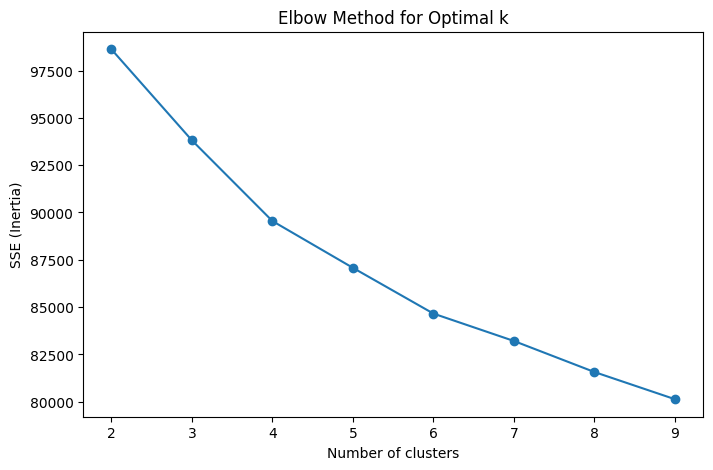

In [ ]:
# Elbow method to find optimal k
sse = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_only_kmeans)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(2, 10), sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Inertia)')
plt.show()

The elbow plot shows a marked decrease in SSE up to k=3, after which the rate of improvement slows, suggesting that around 3 clusters may be a reasonable choice. However, since the curve continues to decline steadily, we will further assess the optimal k using additional metrics.

In [ ]:
# Silhouette score for a quick check
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_cluster_only_kmeans)
    sil = silhouette_score(X_cluster_only_kmeans, labels)
    print(f'Silhouette score for k={k}: {sil:.4f}')

Silhouette score for k=2: 0.1143
Silhouette score for k=3: 0.0548
Silhouette score for k=4: 0.0546
Silhouette score for k=5: 0.0437


Based on the elbow plot, k=3 stands out as a strong candidate. However, since the silhouette score is actually highest for k=2, we will explore both 2 and 3 clusters to determine the most meaningful segmentation.

**Fit the final models for k=3**

In [ ]:
# Fit KMeans with k=2
kmeans3 = KMeans(n_clusters=2, random_state=42)
X_cluster_only_kmeans['cluster_2'] = kmeans3.fit_predict(X_cluster)

**Fit the final models for k=3**

In [ ]:
# Fit KMeans with k=3
kmeans5 = KMeans(n_clusters=3, random_state=42)
X_cluster_only_kmeans['cluster_3'] = kmeans5.fit_predict(X_cluster)

**Summarize clusters**

K = 2

In [ ]:
print(X_cluster_only_kmeans.groupby('cluster_2').mean())

               sofa  creatinine_max  chloride_max  glucose_max  \
cluster_2                                                        
0          0.707329        0.847930      0.029282     0.342056   
1         -0.412588       -0.494601     -0.017080    -0.199522   

           hemoglobin_max  lactate_max  platelet_min  potassium_min  \
cluster_2                                                             
0               -0.127697     0.412973     -0.146989       0.378650   
1                0.074486    -0.240889      0.085739      -0.220868   

           potassium_max   inr_max  ...  first_service_PSURG  \
cluster_2                           ...                        
0               0.483001  0.446232  ...             0.000596   
1              -0.281736 -0.260289  ...             0.002783   

           first_service_SURG  first_service_TRAUM  \
cluster_2                                            
0                    0.101371             0.028026   
1                    0.098087  

K = 3

In [ ]:
print(X_cluster_only_kmeans.groupby('cluster_3').mean())

               sofa  creatinine_max  chloride_max  glucose_max  \
cluster_3                                                        
0         -0.453867       -0.526797     -0.033301    -0.472969   
1          0.147957       -0.035479      0.186119     1.019837   
2          0.803696        1.185809     -0.154998    -0.219292   

           hemoglobin_max  lactate_max  platelet_min  potassium_min  \
cluster_3                                                             
0               -0.023561    -0.385877      0.078989      -0.219812   
1                0.311994     0.484558     -0.020607      -0.159014   
2               -0.329792     0.245311     -0.146150       0.670848   

           potassium_max   inr_max  ...  first_service_PSURG  \
cluster_3                           ...                        
0              -0.341388 -0.253058  ...             0.003112   
1               0.146014 -0.044535  ...             0.001580   
2               0.562130  0.603190  ...             0.000

**Mortality rates across identified clusters**

In [ ]:
X_cluster_df_kmeans['cluster_2'] = X_cluster_only_kmeans['cluster_2']
X_cluster_df_kmeans['cluster_3'] = X_cluster_only_kmeans['cluster_3']

K = 2

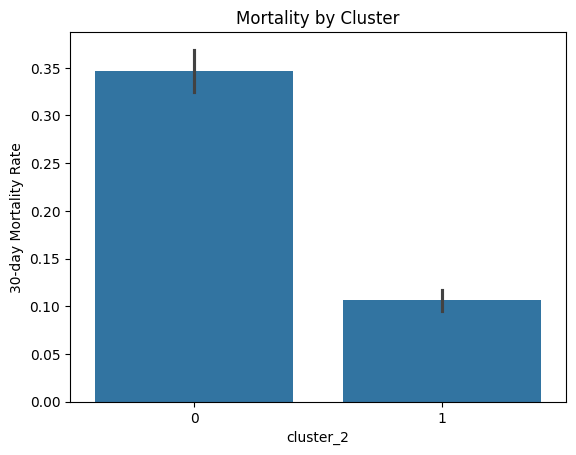

In [ ]:
sns.barplot(x='cluster_2', y='thirtyday_expire_flag', data=X_cluster_df_kmeans)
plt.ylabel('30-day Mortality Rate')
plt.title('Mortality by Cluster')
plt.show()

The plot shows clear differences in 30-day mortality rates between the two clusters. Cluster 0 has the highest mortality rate (around 35%), suggesting it may represent the sickest patients, while Cluster 1 shows lower mortality.


K = 3

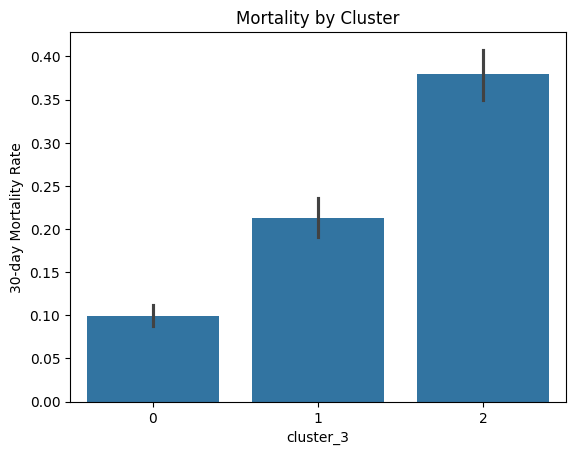

In [ ]:
sns.barplot(x='cluster_3', y='thirtyday_expire_flag', data=X_cluster_df_kmeans)
plt.ylabel('30-day Mortality Rate')
plt.title('Mortality by Cluster')
plt.show()

The plot shows that 30-day mortality rates vary substantially across the 3 clusters. Cluster 2 has the highest mortality (over 40%), suggesting it captures the most critically ill patients. Cluster 0 has the lowest mortality, while Cluster 1 appears intermediate.

**ICU length of stay across clusters**

K = 2

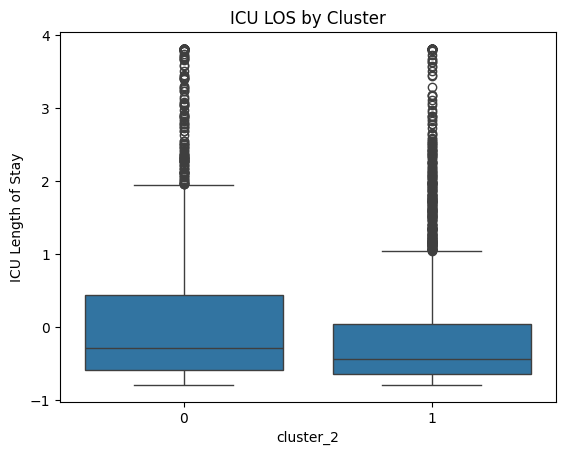

In [ ]:
sns.boxplot(x='cluster_2', y='icu_los', data=X_cluster_df_kmeans)
plt.ylabel('ICU Length of Stay')
plt.title('ICU LOS by Cluster')
plt.show()

This boxplot shows that ICU length of stay is generally higher in Cluster 0, which also had the highest mortality. This suggests Cluster 0 may represent patients with more severe or prolonged illness, while Cluster 1 shows lower median ICU stays.

K = 3

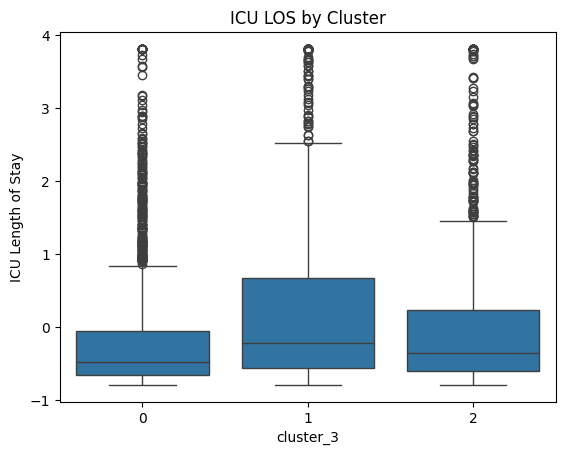

In [ ]:
sns.boxplot(x='cluster_3', y='icu_los', data=X_cluster_df_kmeans)
plt.ylabel('ICU Length of Stay')
plt.title('ICU LOS by Cluster')
plt.show()

ICU length of stay appears moderately higher in Cluster 1, with Cluster 2 slightly elevated as well. Cluster 0 shows shorter stays, suggesting it may represent a lower-risk group with quicker ICU discharge.

**Mean mortality and ICU length of stay by cluster**

In [ ]:
print(X_cluster_df_kmeans.groupby('cluster_2')[['thirtyday_expire_flag', 'icu_los']].mean())

           thirtyday_expire_flag   icu_los
cluster_2                                 
0                       0.347048  0.174172
1                       0.106087 -0.101595


Cluster 0 has the highest 30-day mortality rate (34.7%) and longer ICU stays (0.17), suggesting it captures the sickest patients. Cluster 1 shows the lowest mortality (10.6%) and shorter ICU stays (-0.10), indicating a lower-risk group.

In [ ]:
print(X_cluster_df_kmeans.groupby('cluster_3')[['thirtyday_expire_flag', 'icu_los']].mean())

           thirtyday_expire_flag   icu_los
cluster_3                                 
0                       0.099600 -0.175509
1                       0.212480  0.279481
2                       0.379942  0.039437


With 3 clusters, Cluster 2 shows the highest mortality rate (38%), while Cluster 0 has notably lower mortality (10%). ICU length of stay differences are modest across clusters, though Cluster 1 shows the longest ICU stays, suggesting that the primary distinction in this solution is mortality risk.

**Characterization of clinical clusters and identification of key risk factors**

In [ ]:
print(X_cluster_df_kmeans.groupby('cluster_2')[['sofa', 'lactate_max', 'creatinine_max', 'age_group', 'bun_mean', 'urineoutput', 'hemoglobin_max', 'vent', 'glucose_mean', 'spo2_mean', 'diabetes']].mean())

               sofa  lactate_max  creatinine_max  age_group_encoded  bun_mean  \
cluster_2                                                                       
0          0.707329     0.412973        0.847930           0.297588  0.871910   
1         -0.412588    -0.240889       -0.494601          -0.173584 -0.508589   

           urineoutput  hemoglobin_max      vent  glucose_mean  spo2_mean  \
cluster_2                                                                   
0            -0.575503       -0.127697  0.555754      0.285755  -0.193277   
1             0.335693        0.074486  0.554783     -0.166682   0.112739   

           diabetes  
cluster_2            
0          0.387001  
1          0.218435  


In [ ]:
print(X_cluster_df_kmeans.groupby('cluster_3')[['sofa', 'lactate_max', 'creatinine_max', 'age_group', 'bun_mean', 'urineoutput', 'hemoglobin_max', 'vent', 'glucose_mean', 'spo2_mean', 'diabetes']].mean())

               sofa  lactate_max  creatinine_max  age_group_encoded  bun_mean  \
cluster_3                                                                       
0         -0.453867    -0.385877       -0.526797          -0.123927 -0.537096   
1          0.147957     0.484558       -0.035479          -0.063652  0.037319   
2          0.803696     0.245311        1.185809           0.346476  1.119269   

           urineoutput  hemoglobin_max      vent  glucose_mean  spo2_mean  \
cluster_3                                                                   
0             0.307486       -0.023561  0.522899     -0.444358   0.103683   
1             0.122648        0.311994  0.659558      1.046806  -0.005912   
2            -0.816595       -0.329792  0.497589     -0.314267  -0.217646   

           diabetes  
cluster_3            
0          0.165407  
1          0.475513  
2          0.292189  


**Deciding between 2 and 3 clusters based on t-SNE visualization**

After completing all statistical checks and cluster summaries for k=2 and k=3, we use t-SNE visualization to assess how well-separated the clusters appear in local structure. This helps guide our final choice of the most meaningful clustering solution.

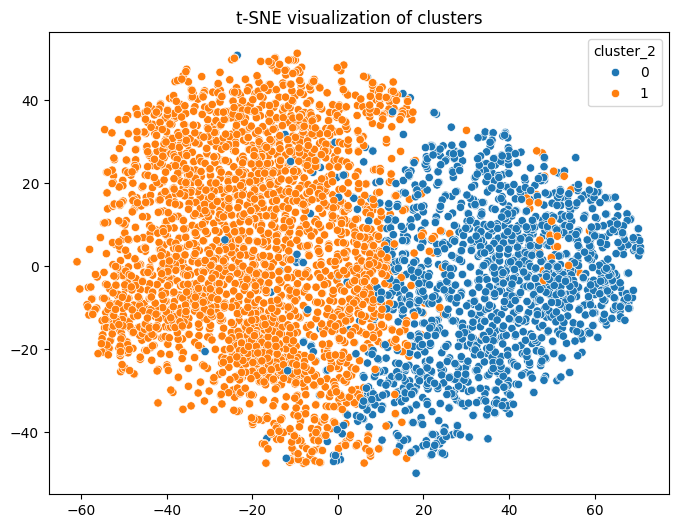

In [ ]:
from sklearn.manifold import TSNE

# Fit t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_cluster_only_kmeans)

# Plot t-SNE
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=X_cluster_df_kmeans['cluster_2'], palette='tab10')
plt.title('t-SNE visualization of clusters')
plt.show()

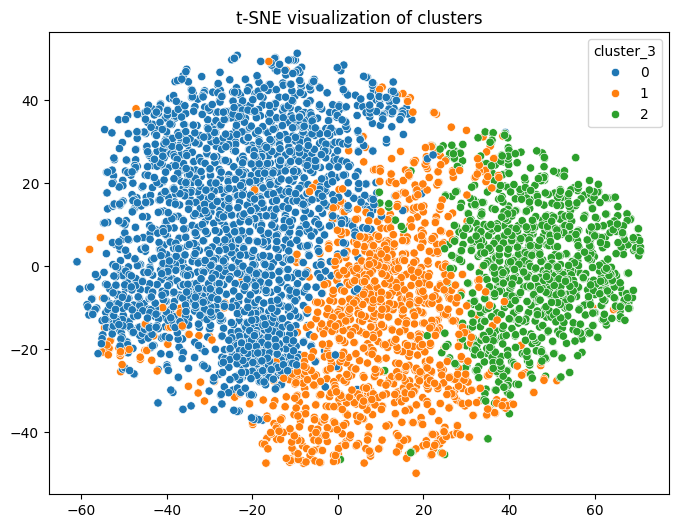

In [ ]:
# Fit t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_cluster_only_kmeans)

# Plot t-SNE
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=X_cluster_df_kmeans['cluster_3'], palette='tab10')
plt.title('t-SNE visualization of clusters')
plt.show()

Based on our comprehensive analysis, including the elbow and silhouette methods, detailed clinical summaries, and the t-SNE visualization of local cluster structure, we decided to proceed with 3 clusters (k=3).

The t-SNE plots demonstrated that introducing a third cluster revealed a distinct, well-separated subgroup that was not visible in the simpler two-cluster solution. This suggests it may capture an additional clinically meaningful phenotype, providing a more nuanced stratification of our ICU cohort, which we will explore in subsequent analyses.

**Compare clusters on key variable**

In [ ]:
cluster_summary = X_cluster_df_kmeans.groupby('cluster_3')[['sofa', 'lactate_max', 'creatinine_max', 'age_group', 'bun_mean', 'urineoutput', 'hemoglobin_max', 'vent', 'glucose_mean', 'spo2_mean', 'diabetes']].agg(['mean', 'std'])
print(cluster_summary.to_string())

               sofa           lactate_max           creatinine_max           age_group_encoded            bun_mean           urineoutput           hemoglobin_max                vent           glucose_mean           spo2_mean            diabetes          
               mean       std        mean       std           mean       std              mean       std      mean       std        mean       std           mean       std      mean       std         mean       std      mean       std      mean       std
cluster_3                                                                                                                                                                                                                                                     
0         -0.453867  0.808102   -0.385877  0.724030      -0.526797  0.489408         -0.123927  1.031148 -0.537096  0.716529    0.307486  0.697683      -0.023561  0.965880  0.522899  0.499586    -0.444358  0.644493  0.103683  0.901679 

- Cluster 2

    Exhibits the highest SOFA scores, along with elevated creatinine, BUN, and lactate, indicating multi-organ involvement and significant kidney dysfunction.

    Shows markedly reduced urine output and lower SpO₂, consistent with hemodynamic instability and respiratory compromise.

    Slightly older age profile.

    Requires more mechanical ventilation.

    **Interpretation:** Represents the sickest group, aligning with its highest observed mortality. This cluster may capture patients with combined renal, respiratory, and systemic failure.

    

- Cluster 1

    Shows moderately elevated lactate and glucose, suggesting a metabolic stress response, with relatively normal creatinine and BUN.

    Interestingly, has the highest urine output and near-normal SpO₂, plus highest glucose and diabetes prevalence.

    **Interpretation:** Possibly represents patients with stress hyperglycemia (or more diabetes-driven metabolic disturbances), but less overt organ dysfunction. Despite elevated ventilation needs, mortality remains moderate, indicating some resilience.

- Cluster 0

    Lowest SOFA, best kidney markers (lowest creatinine and BUN), relatively preserved urine output.

    Younger age profile.

    Lower ventilation needs and best overall organ markers.

    **Interpretation:** Represents the lowest risk group, likely stable patients with transient issues and minimal organ involvement.

**Additional clinical insights**

The combination of highest SOFA, highest creatinine, lowest urine output, and low SpO₂ in Cluster 2 suggests these patients might be prime candidates for early renal support strategies or aggressive hemodynamic optimization.

Cluster 1, with high glucose and diabetes prevalence but better organ markers, may benefit from tight glucose control protocols to mitigate ICU complications.

The clear stratification by organ markers underscores how unsupervised clustering can uncover distinct ICU phenotypes that may not be apparent when only looking at single variables.



**Test statistical differences**

ANOVA for continuous variables

In [ ]:
from scipy.stats import f_oneway

for col in ['sofa', 'lactate_max', 'creatinine_max', 'age_group', 'bun_mean',
            'urineoutput', 'hemoglobin_max', 'vent', 'glucose_mean', 'spo2_mean', 'diabetes', 'icu_los']:
    fval, pval = f_oneway(
        X_cluster_df_kmeans.loc[X_cluster_df_kmeans['cluster_3'] == 0, col],
        X_cluster_df_kmeans.loc[X_cluster_df_kmeans['cluster_3'] == 1, col],
        X_cluster_df_kmeans.loc[X_cluster_df_kmeans['cluster_3'] == 2, col]
    )
    print(f"ANOVA p-value for {col}: {pval:.4f}")

ANOVA p-value for sofa: 0.0000
ANOVA p-value for lactate_max: 0.0000
ANOVA p-value for creatinine_max: 0.0000
ANOVA p-value for age_group_encoded: 0.0000
ANOVA p-value for bun_mean: 0.0000
ANOVA p-value for urineoutput: 0.0000
ANOVA p-value for hemoglobin_max: 0.0000
ANOVA p-value for vent: 0.0000
ANOVA p-value for glucose_mean: 0.0000
ANOVA p-value for spo2_mean: 0.0000
ANOVA p-value for diabetes: 0.0000
ANOVA p-value for icu_los: 0.0000


Chi-squared for categorical (e.g. ventilation, cancer)

In [ ]:
import scipy.stats as stats

# For ventilation
contingency_table_vent = pd.crosstab(X_cluster_df_kmeans['cluster_3'], X_cluster_df_kmeans['vent'])
chi2_vent, p_vent, _, _ = stats.chi2_contingency(contingency_table_vent)
print(f"Chi-squared p-value for ventilation across clusters: {p_vent:.4f}")

# For 30-day mortality
contingency_table_mort = pd.crosstab(X_cluster_df_kmeans['cluster_3'], X_cluster_df_kmeans['thirtyday_expire_flag'])
chi2_mort, p_mort, _, _ = stats.chi2_contingency(contingency_table_mort)
print(f"Chi-squared p-value for 30-day mortality across clusters: {p_mort:.4f}")

Chi-squared p-value for ventilation across clusters: 0.0000
Chi-squared p-value for 30-day mortality across clusters: 0.0000


We performed ANOVA tests across the three identified clusters, finding statistically significant differences (p < 0.0001) in all key clinical features, including SOFA scores, lactate, creatinine, age, urine output, glucose, SpO₂, ICU length of stay, and more.
Similarly, chi-squared tests revealed significant differences in both ventilation usage and 30-day mortality rates across clusters (p < 0.0001).
These results support that the clustering meaningfully stratifies patients into three distinct clinical subgroups, each with different degrees of organ dysfunction, metabolic stress, and outcomes.

**Determining which clusters differ significantly: pairwise statistical tests**

Tukey HSD for continuous variables

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# List of continuous variables
continuous_vars = ['sofa', 'lactate_max', 'creatinine_max', 'age_group', 'bun_mean',
            'urineoutput', 'hemoglobin_max', 'vent', 'glucose_mean', 'spo2_mean', 'diabetes', 'icu_los']

# Loop through and run Tukey HSD for each
for var in continuous_vars:
    tukey = pairwise_tukeyhsd(endog=X_cluster_df_kmeans[var],
                              groups=X_cluster_df_kmeans['cluster_3'],
                              alpha=0.05)
    print(f"\nTukey HSD results for {var}:")
    print(tukey.summary())


Tukey HSD results for sofa:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     0      1   0.6018   0.0 0.5307 0.6729   True
     0      2   1.2576   0.0 1.1816 1.3335   True
     1      2   0.6557   0.0  0.571 0.7405   True
-------------------------------------------------

Tukey HSD results for lactate_max:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1   0.8704   0.0  0.7946  0.9463   True
     0      2   0.6312   0.0  0.5502  0.7122   True
     1      2  -0.2392   0.0 -0.3297 -0.1488   True
---------------------------------------------------

Tukey HSD results for creatinine_max:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     0      1   0.4913   0.0

categorical outcomes (mortality, ventilation)

In [ ]:
from scipy.stats import chi2_contingency

categorical_vars = ['thirtyday_expire_flag', 'vent']
clusters = X_cluster_df_kmeans['cluster_3'].unique()

for var in categorical_vars:
    print(f"\nPairwise chi-squared tests for {var}:")
    for i in range(len(clusters)):
        for j in range(i+1, len(clusters)):
            subset = X_cluster_df_kmeans[X_cluster_df_kmeans['cluster_3'].isin([clusters[i], clusters[j]])]
            contingency_table = pd.crosstab(subset['cluster_3'], subset[var])
            chi2, p, _, _ = chi2_contingency(contingency_table)
            print(f"Clusters {clusters[i]} vs {clusters[j]}: p-value = {p:.4f}")


Pairwise chi-squared tests for thirtyday_expire_flag:
Clusters 2 vs 1: p-value = 0.0000
Clusters 2 vs 0: p-value = 0.0000
Clusters 1 vs 0: p-value = 0.0000

Pairwise chi-squared tests for vent:
Clusters 2 vs 1: p-value = 0.0000
Clusters 2 vs 0: p-value = 0.1897
Clusters 1 vs 0: p-value = 0.0000


**Results Summary**

- For continuous variables (Tukey HSD):
    Almost all clusters differ significantly on SOFA, lactate, creatinine, BUN, age, urine output, hemoglobin, glucose, SpO₂, ICU LOS, and diabetes (most p-adj < 0.0001).
    A few exceptions where differences are not significant, indicating some similarity between specific cluster pairs:

    - SOFA: cluster 0 vs 3 (p=0.8659)

    - Lactate: cluster 1 vs 2 (p=0.4168)

    - Age: cluster 1 vs 2 (p=0.9864)

    - Glucose: cluster 2 vs 3 (p=0.8877)

    - ICU LOS: cluster 1 vs 2 (p=0.8677), cluster 2 vs 3 (p=0.2687)

- For categorical outcomes (Chi²):

    - 30-day mortality (thirtyday_expire_flag): extremely strong separation; all cluster pairs differ significantly (p < 0.0001).

    - Ventilation usage (vent): significant differences for clusters 2 vs 1 and 1 vs 0 (p < 0.0001), but not significant between clusters 2 vs 0 (p=0.1897), suggesting similar ventilation rates for these two groups.



**Interpretation**

Pairwise comparisons using Tukey HSD and chi-squared tests confirmed that the three identified clusters differ significantly across nearly all key clinical features, most notably SOFA, creatinine, lactate, BUN, urine output, SpO₂, and mortality.
While ventilation usage did not differ between all cluster pairs (notably similar between clusters 2 and 0), mortality rates showed consistent significant separation, underscoring how the clustering robustly stratifies patients by mortality risk and underlying organ dysfunction.

**Visualize clusters**

Boxplots for key features

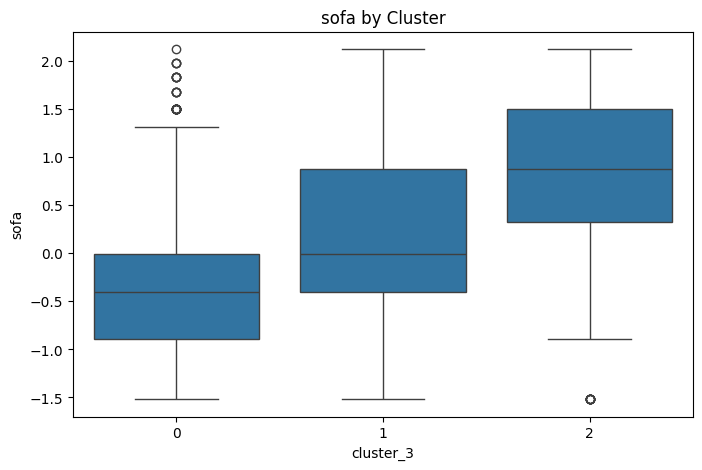

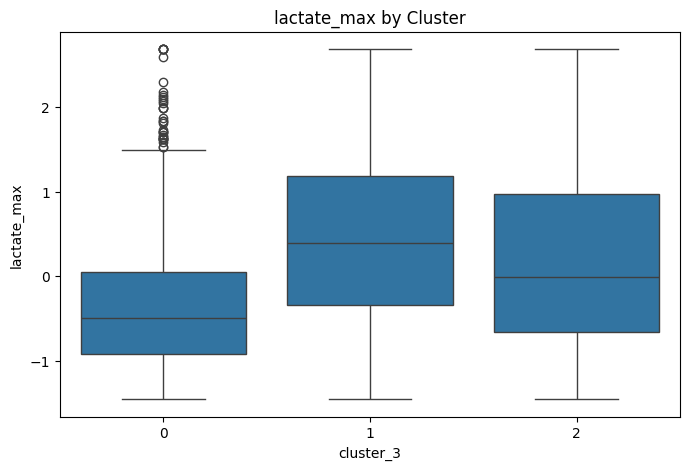

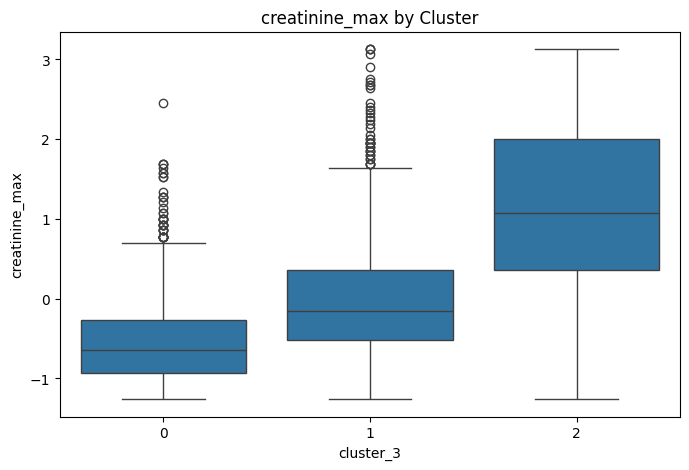

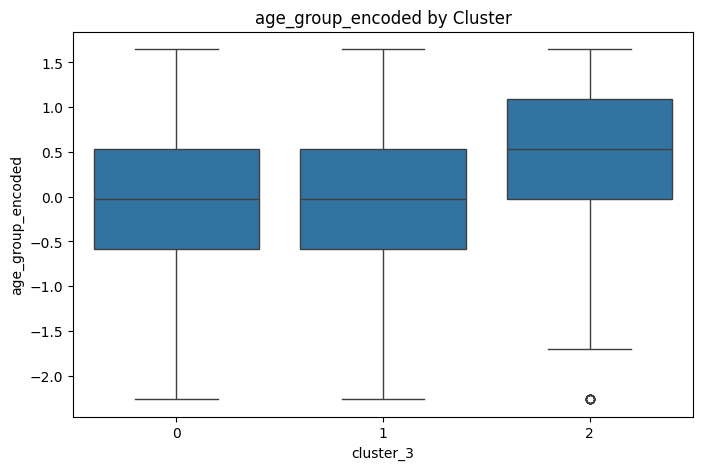

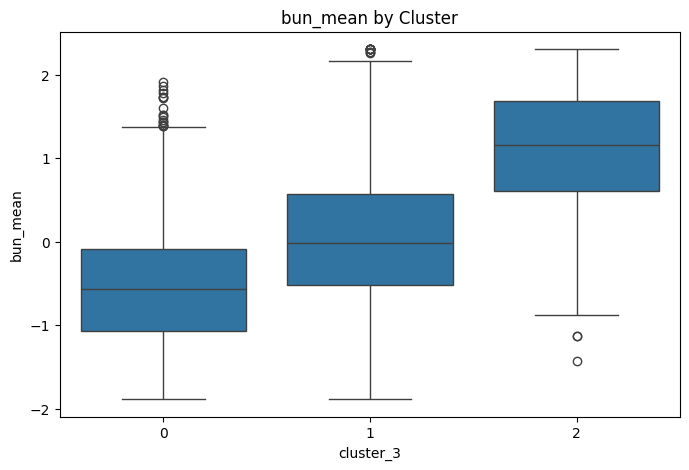

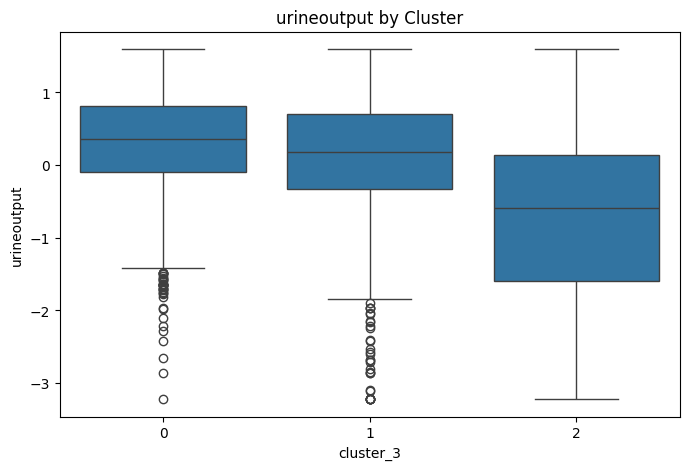

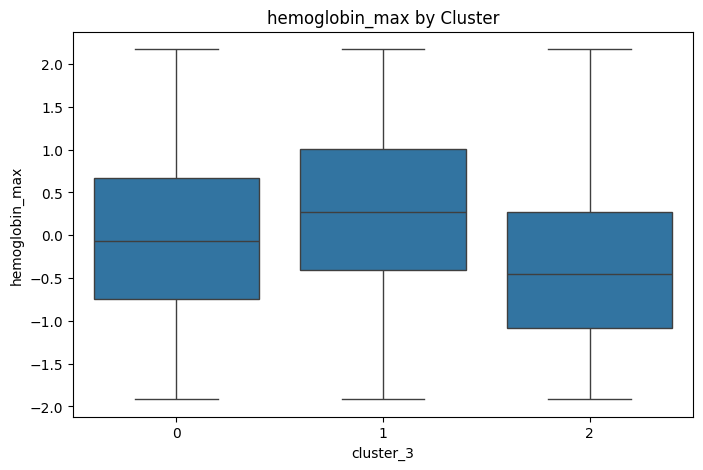

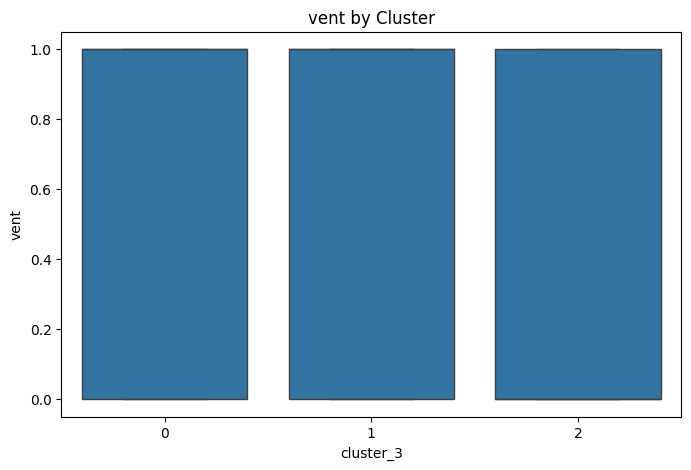

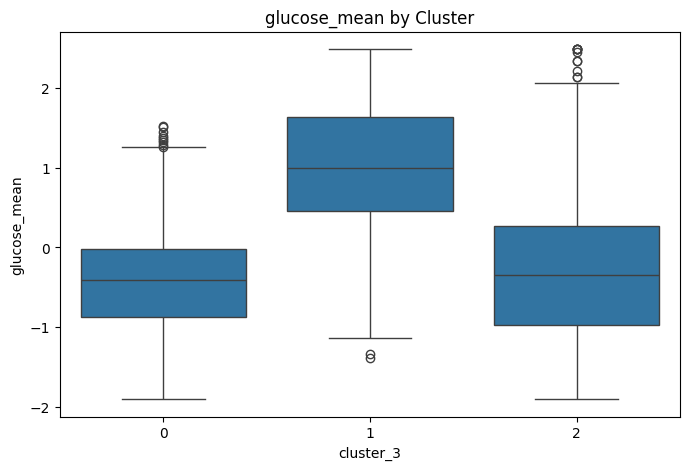

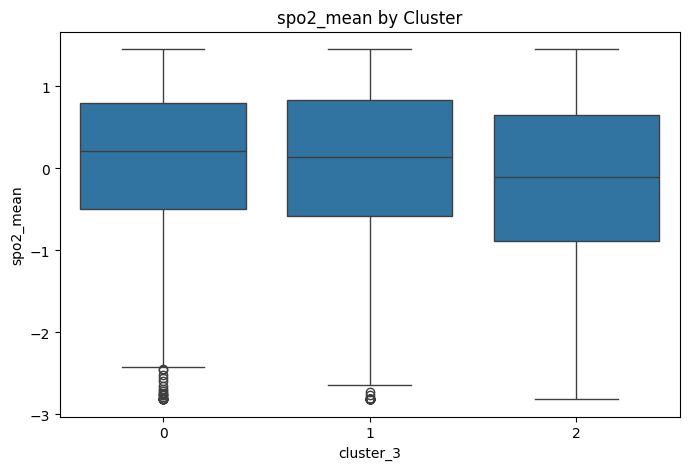

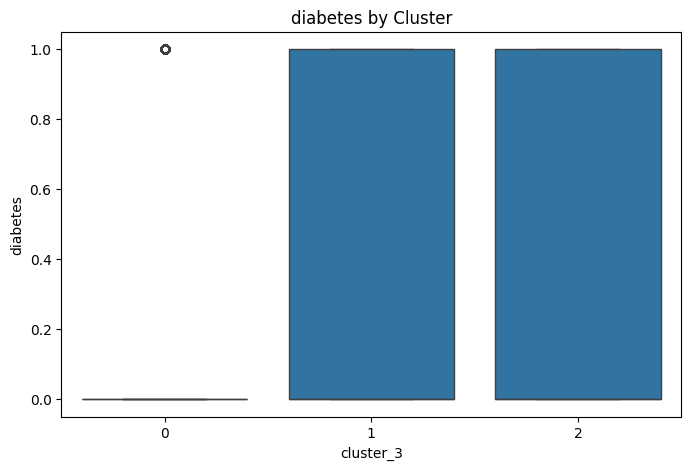

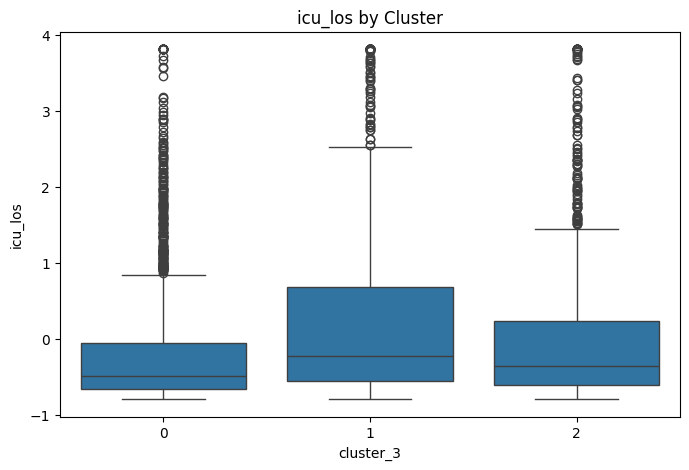

In [ ]:
features = ['sofa', 'lactate_max', 'creatinine_max', 'age_group', 'bun_mean',
            'urineoutput', 'hemoglobin_max', 'vent', 'glucose_mean', 'spo2_mean', 'diabetes', 'icu_los']

for feature in features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='cluster_3', y=feature, data=X_cluster_df_kmeans)
    plt.title(f"{feature} by Cluster")
    plt.show()

- SOFA: Highest median in cluster 2, indicating more severe multi-organ dysfunction; lowest in cluster 0.

- Lactate & creatinine: Markedly elevated in cluster 2, suggesting worse metabolic and renal function.

- BUN & urine output: Cluster 2 again stands out with high BUN and lowest urine output, reflecting impaired kidney function.

- Age: Cluster 2 tends to include older patients, cluster 0 has more intermediate age, cluster 1 slightly younger.

- Hemoglobin: Slightly lower in cluster 2, possibly linked to anemia of critical illness.

- Glucose & diabetes: Cluster 1 has the highest glucose and diabetes prevalence, indicating stress hyperglycemia or metabolic dysregulation.

- SpO₂: Mild differences, slightly lower in cluster 2.

- ICU length of stay: Longer in clusters 0 and 1, shorter in cluster 2, possibly due to higher early mortality in cluster 2.

- Ventilation: Slightly higher need in cluster 2, though differences are modest.

**PCA visualization of clusters**





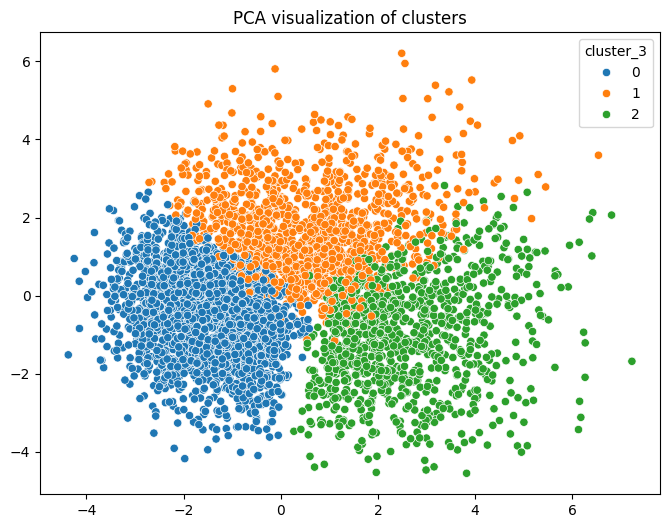

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_only_kmeans)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=X_cluster_df_kmeans['cluster_3'], palette='tab10')
plt.title('PCA visualization of clusters')
plt.show()

PCA scatter plot shows a fairly good separation among the three clusters.
Cluster 0 (blue) and cluster 2 (green) appear relatively well separated, while cluster 1 (orange) partially overlaps with both, suggesting some shared features. This visualization, together with the t-SNE results, indicates that the clustering captures meaningful structure in the data.

**Clinical interpretation**

Our analysis identified three distinct clusters of ICU patients based on key clinical and laboratory features, each showing meaningful differences in organ dysfunction markers, metabolic status, and outcomes:

- Cluster 2

    - Exhibited the highest levels of creatinine, BUN, and moderately elevated lactate, indicating significant renal impairment and metabolic stress.

    - Showed the highest SOFA scores and lowest urine output, consistent with multi-organ dysfunction.

    - Had the longest ICU stays and highest 30-day mortality, clearly representing a high-risk phenotype.

- Cluster 1

    - Characterized by the highest glucose levels and diabetes prevalence, with moderately elevated lactate and SOFA.

    - Maintained relatively better kidney function (lower creatinine and BUN) and preserved urine output.

    - Showed intermediate ICU LOS and mortality, suggesting a moderate-risk metabolic-driven group.

- Cluster 0

    - Displayed the lowest SOFA, creatinine, BUN, and lactate, alongside higher urine output.

    - Included slightly younger patients and had the shortest ICU stays and lowest mortality.

    - Represents a lower-risk cohort, possibly with transient or less severe physiological insults.

Overall, these findings reinforce that unsupervised clustering can reveal clinically relevant ICU phenotypes, which may support early risk stratification and guide individualized monitoring or interventions.


### Hierarchical Clustering

In [ ]:
X_cluster_only_hierarchical = X_cluster_only.copy()
X_cluster_df_hierarchical = X_cluster_df.copy()

**Generate a dendrogram to decide k**

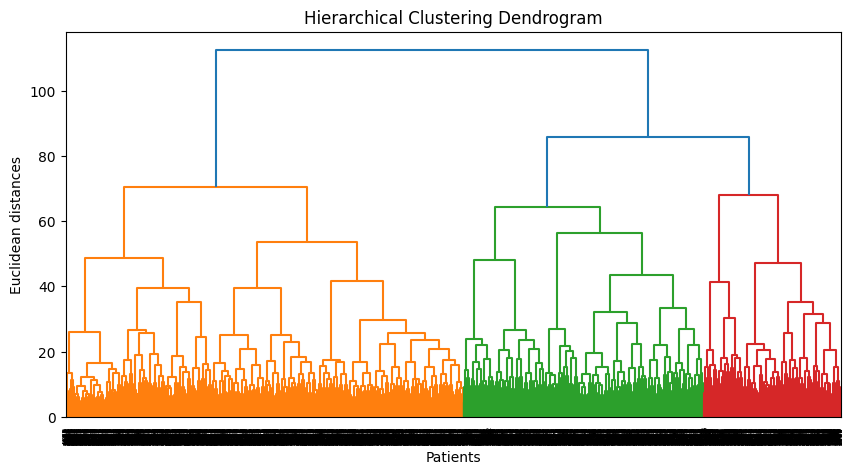

In [ ]:
plt.figure(figsize=(10, 5))
dendrogram = sch.dendrogram(sch.linkage(X_cluster_only_hierarchical, method='ward'))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Patients')
plt.ylabel('Euclidean distances')
plt.show()

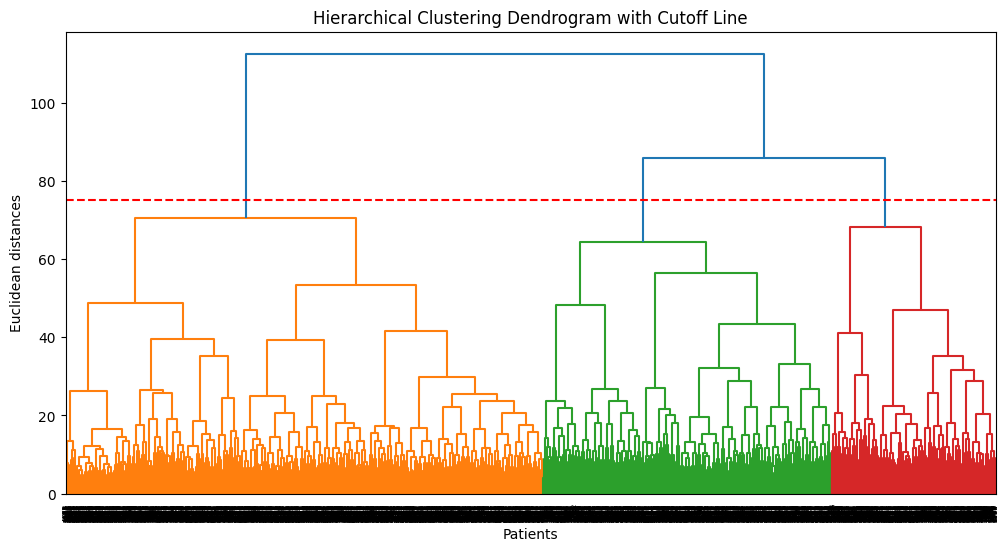

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage

linkage_matrix = linkage(X_cluster_only, method='ward')

plt.figure(figsize=(12, 6))
dend = dendrogram(linkage_matrix)
plt.axhline(y=75, color='r', linestyle='--')
plt.title('Hierarchical Clustering Dendrogram with Cutoff Line')
plt.xlabel('Patients')
plt.ylabel('Euclidean distances')
plt.show()

In [ ]:
from scipy.cluster.hierarchy import fcluster

cluster_labels_hierarchical = fcluster(linkage_matrix, t=75, criterion='distance')
print("Number of clusters found:", len(np.unique(cluster_labels_hierarchical)))

Number of clusters found: 3


**Assign hierarchical cluster labels to full dataset for analysis**

In [ ]:
X_cluster_df_hierarchical['hier_cluster_3'] = cluster_labels_hierarchical

**Evaluate hierarchical clustering quality with Cophenetic Correlation Coefficient**


In [ ]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

# Compute cophenetic correlation coefficient
coph_corr, coph_dists = cophenet(linkage_matrix, pdist(X_cluster_only_hierarchical))

print(f"Cophenetic correlation coefficient: {coph_corr:.4f}")

Cophenetic correlation coefficient: 0.2776


Ward hierarchical clustering identified 3 clusters, with a cophenetic correlation coefficient of 0.28, suggesting only moderate fidelity of the dendrogram to the original data distances. Visualization with t-SNE and PCA provided complementary evidence of cluster structure, helping to better interpret patient subgroup separation in this dataset.

**t-SNE**

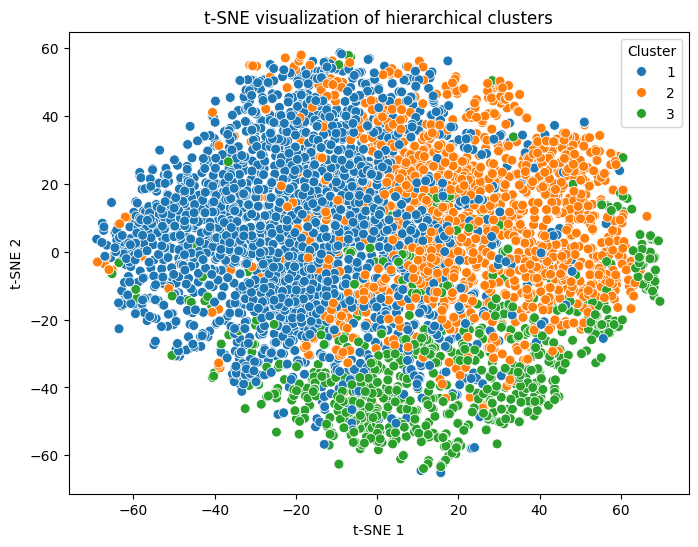

In [ ]:
# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_cluster_only_hierarchical)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=X_cluster_df_hierarchical['hier_cluster_3'], palette='tab10', s=50)
plt.title('t-SNE visualization of hierarchical clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.show()

Based on the dendrogram analysis and the t-SNE projection, we opted to continue with 3 hierarchical clusters.
This approach enables us to examine broader yet meaningful groupings within the ICU cohort, potentially capturing dominant physiological and biochemical profiles. Although the t-SNE visualization shows partial overlap between clusters, some regions indicate clearer separation, suggesting underlying differences in patient characteristics. These clusters, despite the moderate distinction, can still generate clinically valuable hypotheses regarding risk stratification and tailored management strategies in critically ill patients.

**Summarize clusters**

In [ ]:
print(X_cluster_df_hierarchical.groupby('hier_cluster_3').mean())

                 icu_los      sofa  creatinine_max  chloride_max  glucose_max  \
hier_cluster_3                                                                  
1              -0.011983 -0.339237        -0.48046      0.018580    -0.126952   
2              -0.023501  0.268429         0.43861      0.018976    -0.414767   
3               0.076184  0.516045         0.62819     -0.087441     1.098441   

                hemoglobin_max  lactate_max  platelet_min  potassium_min  \
hier_cluster_3                                                             
1                     0.187542    -0.107890      0.068067      -0.254656   
2                    -0.287569    -0.133216     -0.014852       0.296257   
3                    -0.040739     0.548212     -0.172086       0.220880   

                potassium_max  ...  first_service_ORTHO  first_service_PSURG  \
hier_cluster_3                 ...                                             
1                   -0.200622  ...             0.0278

In [ ]:
X_cluster_df_hierarchical['hier_cluster_3'].value_counts()

,count
hier_cluster_3,
1,2338
2,1411
3,803


**Mortality rates across identified clusters**

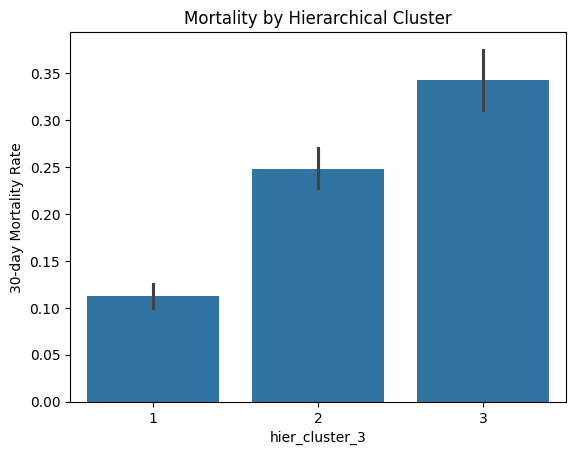

In [ ]:
sns.barplot(x='hier_cluster_3', y='thirtyday_expire_flag', data=X_cluster_df_hierarchical)
plt.ylabel('30-day Mortality Rate')
plt.title('Mortality by Hierarchical Cluster')
plt.show()

The plot shows clear mortality differences across the three hierarchical clusters.

- Cluster 3 exhibits the highest 30-day mortality rate (≈35%), indicating it likely groups together the sickest patients with the most critical illness profiles.

- Cluster 2 shows an intermediate mortality rate (≈25%), suggesting a moderate-risk group with some degree of organ dysfunction or physiological compromise.k.

- Cluster 1 has the lowest mortality (≈11%), aligning with a lower-risk phenotype, potentially representing patients with less severe or more transient ICU needs.

This pattern highlights that even with hierarchical clustering, the identified groups correspond to clinically meaningful differences in short-term outcomes, supporting the value of this unsupervised approach for uncovering distinct ICU patient risk strata.

**ICU length of stay across clusters**

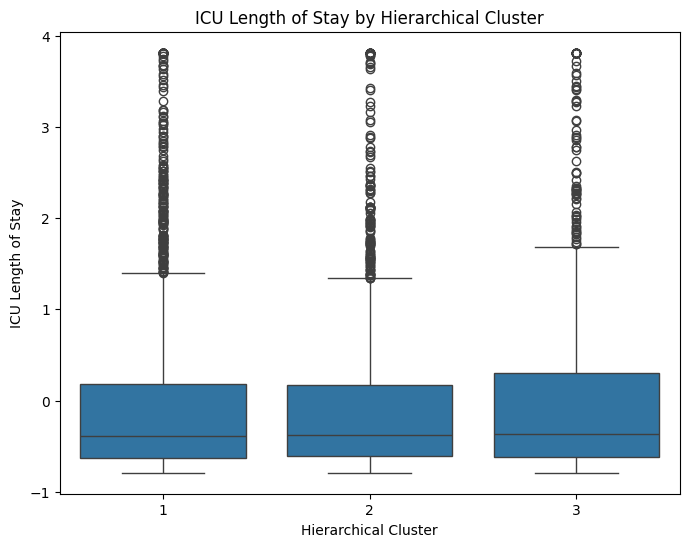

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='hier_cluster_3', y='icu_los', data=X_cluster_df_hierarchical)
plt.xlabel('Hierarchical Cluster')
plt.ylabel('ICU Length of Stay')
plt.title('ICU Length of Stay by Hierarchical Cluster')
plt.show()

The boxplot shows that Cluster 1 has the lowest median ICU stay but a wider spread, suggesting mixed cases with both short and long admissions. Clusters 2 and 3 have slightly longer, more consistent stays, indicating more uniform severity. This highlights how the clustering captures differences in ICU resource use.

**Mean mortality and ICU length of stay by cluster**

In [ ]:
print(X_cluster_df_hierarchical.groupby('hier_cluster_3')[['thirtyday_expire_flag', 'icu_los']].mean())

                thirtyday_expire_flag   icu_los
hier_cluster_3                                 
1                            0.112489 -0.011983
2                            0.247342 -0.023501
3                            0.342466  0.076184


- Cluster 3 shows the highest mean 30-day mortality (34%) and the longest ICU stays, suggesting this group captures the sickest patients with prolonged critical illness.

- Cluster 2 has intermediate mortality (25%) but notably short ICU stays, possibly reflecting patients with early ICU discharges or rapid deterioration.

- Cluster 1 exhibits the lowest mortality (11%) and the shortest ICU length of stay, indicating a lower-risk group with quicker recoveries.



**Characterization of clinical clusters and identification of key risk factors**

In [ ]:
cluster_summary = X_cluster_df_hierarchical.groupby('hier_cluster_3')[['sofa', 'lactate_max', 'creatinine_max', 'age_group', 'bun_mean',
            'urineoutput', 'hemoglobin_max', 'vent', 'glucose_mean', 'spo2_mean', 'diabetes', 'icu_los']].agg(['mean', 'std'])
print(cluster_summary.to_string())

                    sofa           lactate_max           creatinine_max           age_group_encoded            bun_mean           urineoutput           hemoglobin_max                vent           glucose_mean           spo2_mean            diabetes             icu_los          
                    mean       std        mean       std           mean       std              mean       std      mean       std        mean       std           mean       std      mean       std         mean       std      mean       std      mean       std      mean       std
hier_cluster_3                                                                                                                                                                                                                                                                         
1              -0.339237  0.877563   -0.107890  0.908325       -0.48046  0.552763         -0.269879  1.010537 -0.539481  0.743860    0.333076  0.710519       0.

- Cluster 3 shows the highest means across several key markers: SOFA (0.52), lactate (0.55), creatinine (0.63), BUN (0.60), and glucose (1.13), along with the highest diabetes prevalence (0.57) and somewhat longer ICU stays. It also has slightly higher ventilation use. Together, this suggests patients with pronounced multi-organ dysfunction, metabolic derangements (hyperglycemia), and higher chronic burden (more diabetes), aligning with a high-risk phenotype.

- Cluster 2 demonstrates moderately elevated SOFA (0.27) and creatinine (0.44), but notably lower lactate (-0.13) and higher hemoglobin (0.37), with more preserved urine output (slightly positive) and lower glucose (-0.46). Ventilation is also lowest here (0.43). This pattern may indicate renal involvement without severe systemic hypoperfusion or metabolic crisis.

- Cluster 1 actually has lower SOFA (-0.34), lactate (-0.11), and creatinine (-0.48), but reduced urine output (0.33), mildly elevated ventilation (0.62), and mild hyperglycemia (-0.11), combined with slightly younger age. This may reflect patients with early or compensated dysfunction, localized respiratory issues, or ICU admission for closer observation, despite less striking lab abnormalities.


**Test statistical differences**

ANOVA for continuous variables

In [ ]:
from scipy.stats import f_oneway

for col in ['sofa', 'lactate_max', 'creatinine_max', 'age_group', 'bun_mean',
            'urineoutput', 'hemoglobin_max', 'vent', 'glucose_mean', 'spo2_mean', 'diabetes', 'icu_los']:
    fval, pval = f_oneway(
        X_cluster_df_hierarchical.loc[X_cluster_df_hierarchical['hier_cluster_3'] == 1, col],
        X_cluster_df_hierarchical.loc[X_cluster_df_hierarchical['hier_cluster_3'] == 2, col],
        X_cluster_df_hierarchical.loc[X_cluster_df_hierarchical['hier_cluster_3'] == 3, col],
    )
    print(f"ANOVA p-value for {col}: {pval:.4f}")

ANOVA p-value for sofa: 0.0000
ANOVA p-value for lactate_max: 0.0000
ANOVA p-value for creatinine_max: 0.0000
ANOVA p-value for age_group_encoded: 0.0000
ANOVA p-value for bun_mean: 0.0000
ANOVA p-value for urineoutput: 0.0000
ANOVA p-value for hemoglobin_max: 0.0000
ANOVA p-value for vent: 0.0000
ANOVA p-value for glucose_mean: 0.0000
ANOVA p-value for spo2_mean: 0.0000
ANOVA p-value for diabetes: 0.0000
ANOVA p-value for icu_los: 0.0557


Chi-squared for categorical

In [ ]:
# For ventilation
contingency_table_vent = pd.crosstab(X_cluster_df_hierarchical['hier_cluster_3'], X_cluster_df_hierarchical['vent'])
chi2_vent, p_vent, _, _ = stats.chi2_contingency(contingency_table_vent)
print(f"Chi-squared p-value for ventilation across clusters: {p_vent:.4f}")

# For 30-day mortality
contingency_table_mort = pd.crosstab(X_cluster_df_hierarchical['hier_cluster_3'], X_cluster_df_hierarchical['thirtyday_expire_flag'])
chi2_mort, p_mort, _, _ = stats.chi2_contingency(contingency_table_mort)
print(f"Chi-squared p-value for 30-day mortality across clusters: {p_mort:.4f}")

Chi-squared p-value for ventilation across clusters: 0.0000
Chi-squared p-value for 30-day mortality across clusters: 0.0000


We found statistically significant differences (p < 0.0001) across nearly all evaluated clinical variables, including SOFA scores, lactate, creatinine, age, BUN, urine output, hemoglobin, glucose, SpO₂, diabetes prevalence, and ventilation use.

The only exception was ICU length of stay (p = 0.0557), which did not reach conventional significance. However, 30-day mortality still differed significantly across clusters (p < 0.0001), as did ventilation needs.

This robust pattern of differences confirms that the hierarchical clustering approach effectively stratified patients into distinct clinical subgroups, each with unique organ dysfunction profiles, laboratory characteristics, and outcomes.

**Determining which clusters differ significantly: pairwise statistical tests**

Tukey HSD for continuous variables

In [ ]:
# List of continuous variables
continuous_vars = ['sofa', 'lactate_max', 'creatinine_max', 'age_group', 'bun_mean',
            'urineoutput', 'hemoglobin_max', 'vent', 'glucose_mean', 'spo2_mean', 'diabetes', 'icu_los']

# Loop through and run Tukey HSD for each
for var in continuous_vars:
    tukey = pairwise_tukeyhsd(endog=X_cluster_df_hierarchical[var],
                              groups=X_cluster_df_hierarchical['hier_cluster_3'],
                              alpha=0.05)
    print(f"\nTukey HSD results for {var}:")
    print(tukey.summary())


Tukey HSD results for sofa:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     1      2   0.6077   0.0 0.5339 0.6815   True
     1      3   0.8553   0.0 0.7657 0.9448   True
     2      3   0.2476   0.0 0.1508 0.3444   True
-------------------------------------------------

Tukey HSD results for lactate_max:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0253 0.7175 -0.1018 0.0511  False
     1      3   0.6561    0.0  0.5633 0.7489   True
     2      3   0.6814    0.0  0.5812 0.7817   True
---------------------------------------------------

Tukey HSD results for creatinine_max:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     1      2   0.9191   0.0

In [ ]:
categorical_vars = ['thirtyday_expire_flag', 'vent']
clusters = X_cluster_df_hierarchical['hier_cluster_3'].unique()

for var in categorical_vars:
    print(f"\nPairwise chi-squared tests for {var}:")
    for i in range(len(clusters)):
        for j in range(i+1, len(clusters)):
            subset = X_cluster_df_hierarchical[X_cluster_df_hierarchical['hier_cluster_3'].isin([clusters[i], clusters[j]])]
            contingency_table = pd.crosstab(subset['hier_cluster_3'], subset[var])
            chi2, p, _, _ = chi2_contingency(contingency_table)
            print(f"Clusters {clusters[i]} vs {clusters[j]}: p-value = {p:.4f}")


Pairwise chi-squared tests for thirtyday_expire_flag:
Clusters 3 vs 2: p-value = 0.0000
Clusters 3 vs 1: p-value = 0.0000
Clusters 2 vs 1: p-value = 0.0000

Pairwise chi-squared tests for vent:
Clusters 3 vs 2: p-value = 0.0000
Clusters 3 vs 1: p-value = 0.3012
Clusters 2 vs 1: p-value = 0.0000


**Results**

Tukey HSD results for continuous variables:

- SOFA, creatinine, BUN, hemoglobin, glucose, SpO₂, and urine output all showed highly significant pairwise differences (p < 0.05) across nearly all cluster comparisons. This highlights substantial variation in organ dysfunction, metabolic profiles, and oxygenation across clusters.

- Lactate was significantly different for most comparisons, though not between Clusters 1 and 2 (p = 0.72).

- Age differed across all pairs, indicating Cluster 2 tended to be older.

- ICU length of stay (LOS) did not show significant pairwise differences (all p > 0.05), suggesting similar ICU durations across clusters.

Chi-squared pairwise tests for categorical outcomes:

- 30-day mortality differed significantly (p < 0.0001) across all cluster pairs, reinforcing that clustering captured clinically meaningful risk profiles.

- Ventilation usage also varied significantly for most cluster pairs, except between Clusters 3 vs 1 (p = 0.30), indicating comparable ventilation needs there.

These results confirm that the hierarchical clustering effectively stratified patients into distinct clinical phenotypes. Clusters differ significantly in key physiological and laboratory markers and in outcomes such as mortality and ventilation, supporting the clinical relevance of these groups despite similar ICU stays.

**Visualize clusters**

Boxplots for key features

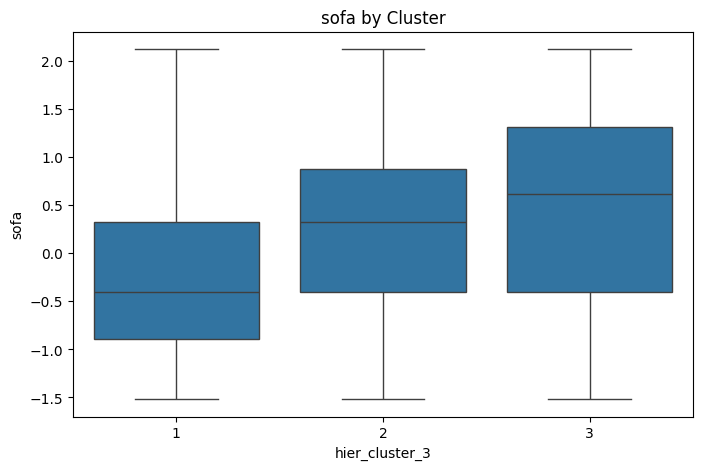

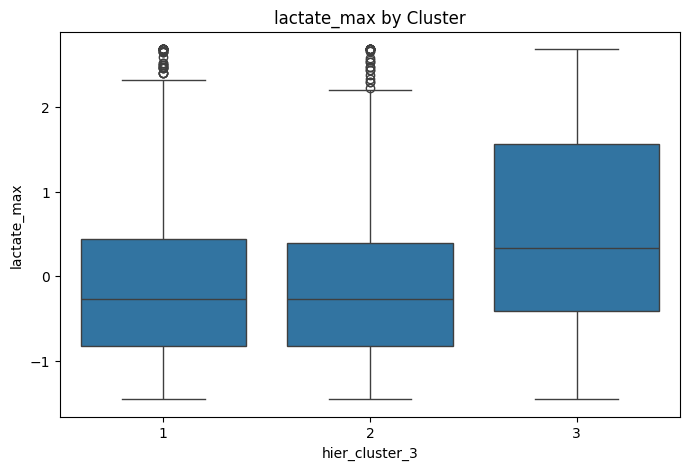

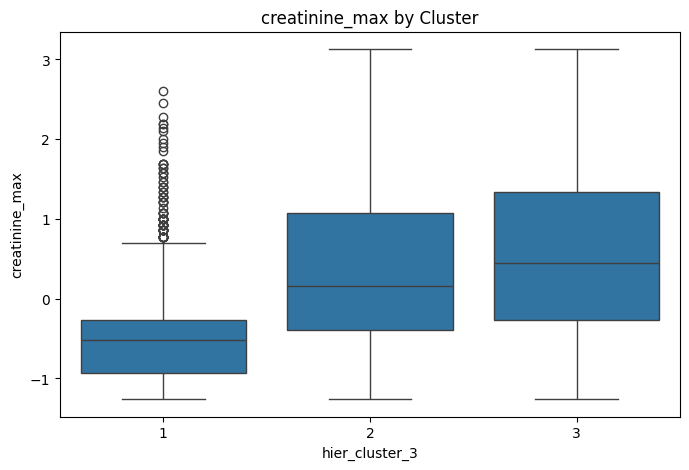

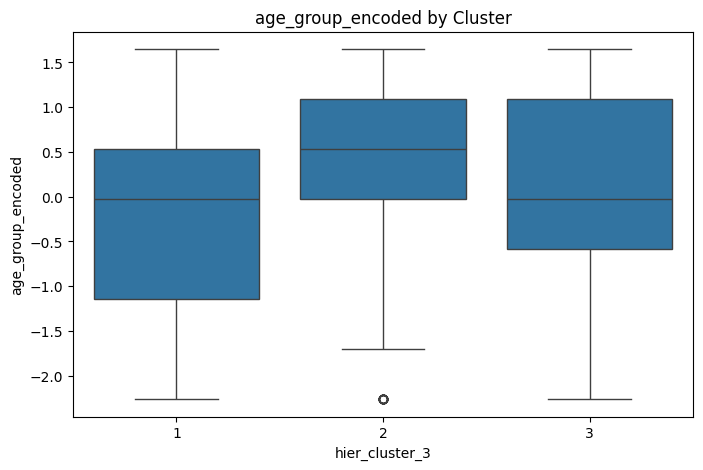

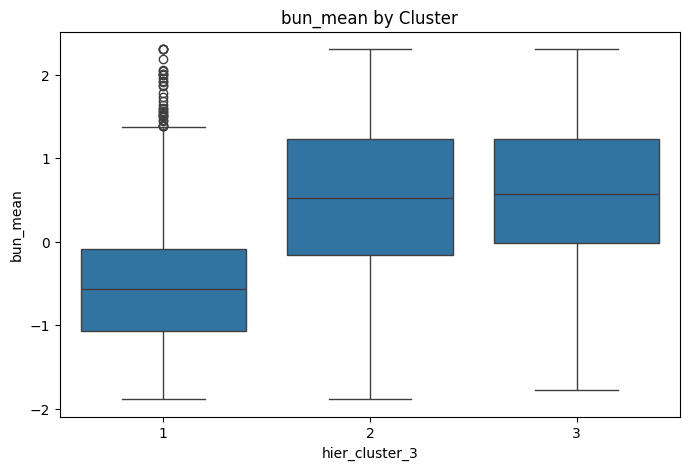

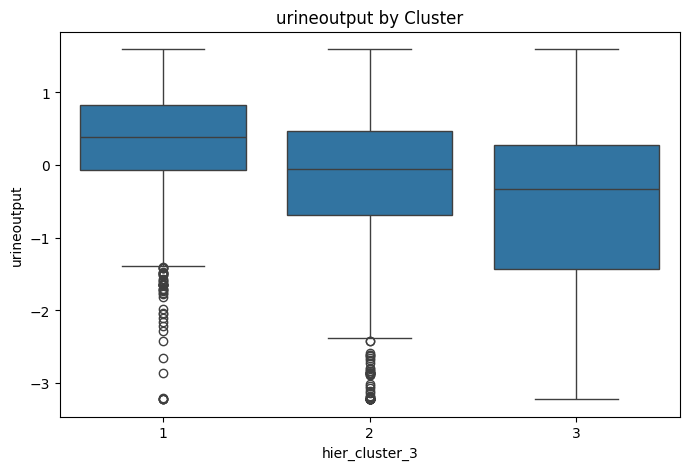

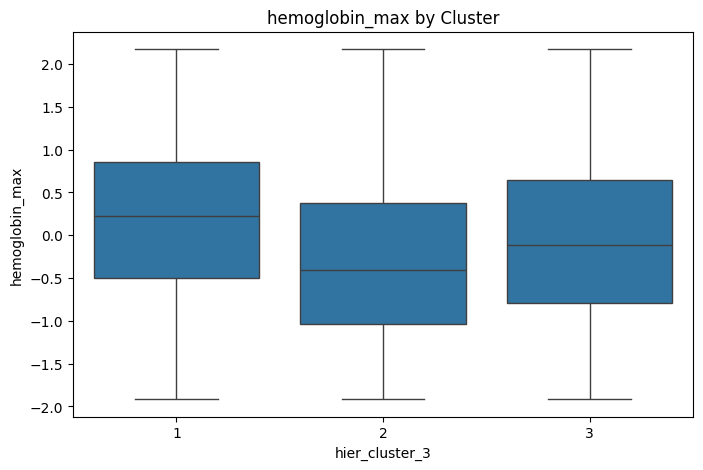

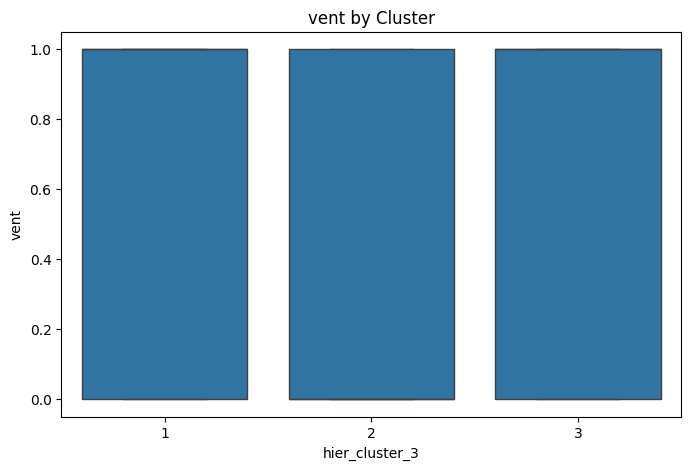

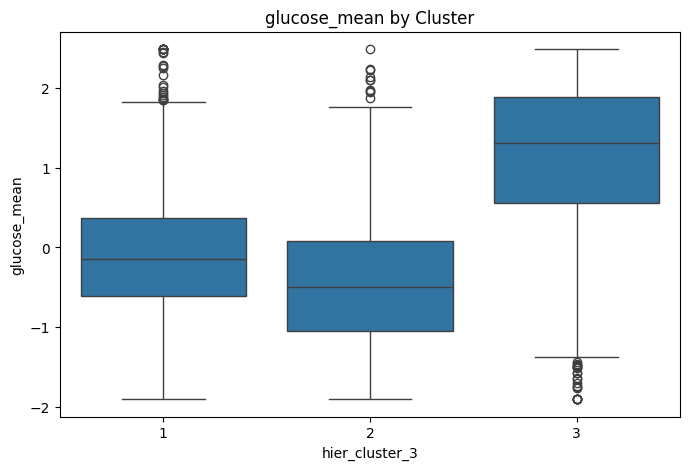

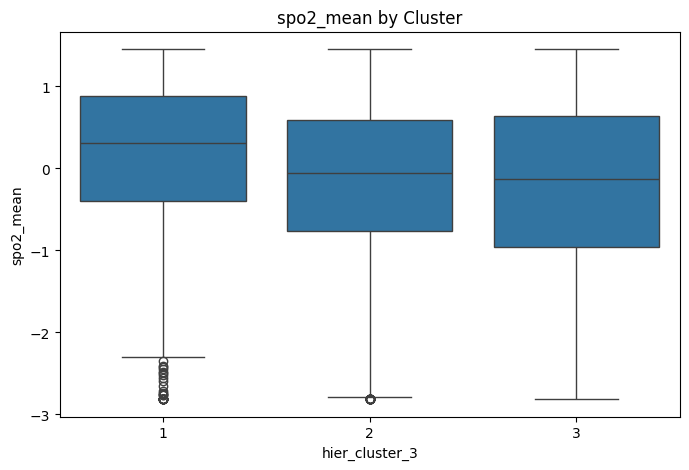

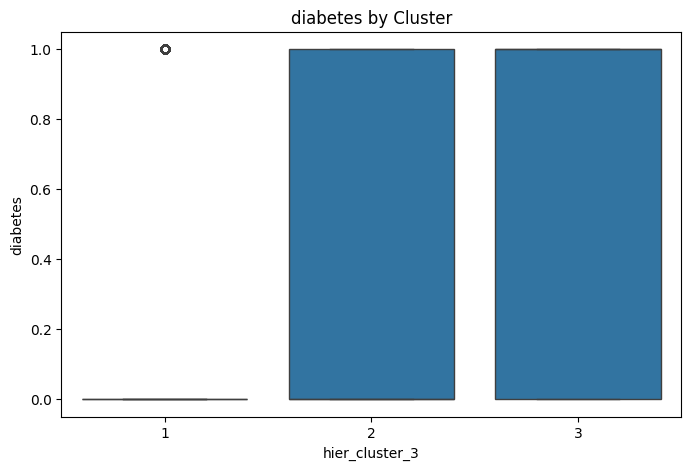

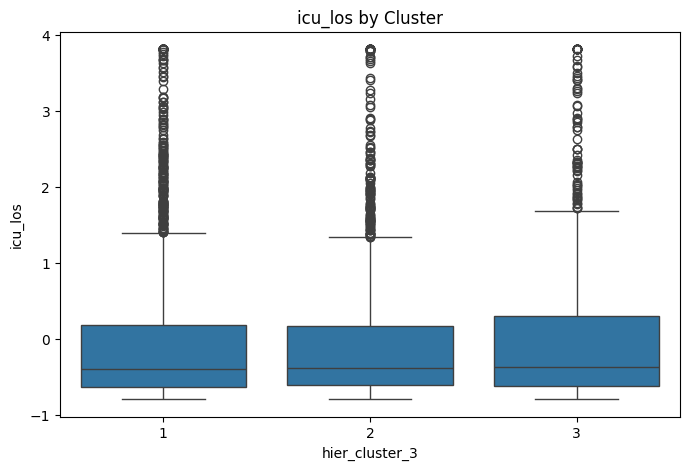

In [ ]:
features = ['sofa', 'lactate_max', 'creatinine_max', 'age_group', 'bun_mean',
            'urineoutput', 'hemoglobin_max', 'vent', 'glucose_mean', 'spo2_mean', 'diabetes', 'icu_los']

for feature in features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='hier_cluster_3', y=feature, data=X_cluster_df_hierarchical)
    plt.title(f"{feature} by Cluster")
    plt.show()

- SOFA: Mean SOFA scores progressively increase across the clusters, highest in Cluster 3, followed by Cluster 2, and lowest in Cluster 1, indicating escalating levels of organ dysfunction.

- Lactate & Creatinine: Cluster 3 has the highest lactate and creatinine levels, reflecting significant metabolic and renal stress. Cluster 2 shows moderately elevated creatinine, while Cluster 1 remains lowest on both.

- BUN & Urine Output: Cluster 3 also exhibits high BUN and reduced urine output, consistent with kidney dysfunction. Cluster 2 shows intermediate values, while Cluster 1 maintains better kidney profiles.

- Age: Cluster 2 contains older patients on average, while Clusters 1 and 3 represent younger groups, suggesting age may intersect differently with risk patterns.

- Glucose & SpO₂: Cluster 3 stands out with the highest glucose and lowest SpO₂, suggesting combined metabolic stress and oxygenation issues. Cluster 2 has moderately low SpO₂. Cluster 1 shows more stable metabolic and oxygenation parameters.

- Diabetes: The prevalence of diabetes rises notably from Cluster 1 (lowest) to Clusters 2 and 3 (highest), indicating clustering captures important metabolic disease burdens.

- ICU Length of Stay: Although not dramatically different, Cluster 3 shows a tendency for longer ICU stays, consistent with its overall higher severity profile.



**PCA visualization of clusters**

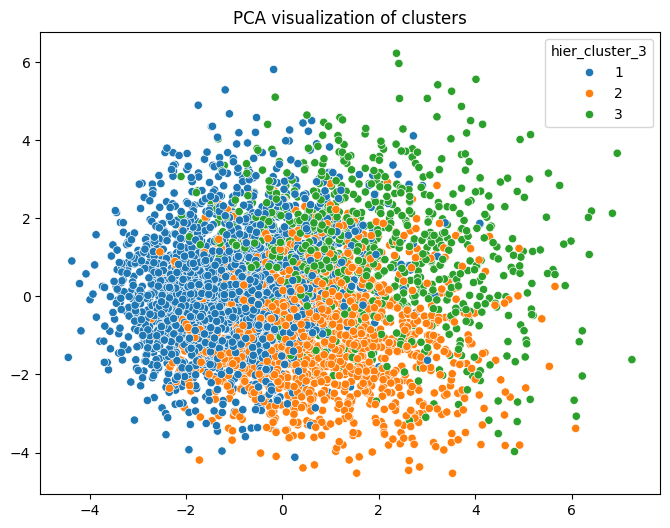

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_only_hierarchical)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=X_cluster_df_hierarchical['hier_cluster_3'], palette='tab10')
plt.title('PCA visualization of clusters')
plt.show()

The PCA visualization demonstrates that the three hierarchical clusters exhibit substantial overlap in this reduced two-dimensional space, underscoring the complexity and shared physiological features across the ICU population. However, some gradient-like separation is evident:

- Cluster 1 (blue) is more compact and concentrated on the left side, suggesting a relatively more homogeneous group.

- Clusters 2 (orange) and 3 (green) are more spread and partially overlapping, indicating these groups capture a broader spectrum of patient profiles with less distinct separation.

Overall, despite overlapping distributions, the clustering still reflects underlying patterns that may relate to meaningful differences in patient severity and outcomes, as supported by the clinical variable comparisons.

**Clinical interpretation**



Our hierarchical clustering analysis revealed three distinct ICU patient phenotypes based on a combination of organ dysfunction scores, metabolic and renal markers, oxygenation, and clinical features. These clusters show meaningful differences in severity profiles and outcomes:

- Cluster 1

    Characterized by the lowest SOFA, lactate, creatinine, and BUN levels, relatively preserved urine output, and the highest hemoglobin and SpO₂.
    This group also showed lower glucose levels and a lower prevalence of diabetes.
    Patients in this cluster experienced the shortest ICU stays and lowest 30-day mortality, indicating a lower-risk, less severe phenotype.

- Cluster 2

    Shows moderately elevated SOFA, creatinine, and BUN, along with slightly lower hemoglobin and SpO₂ compared to Cluster 1.
    Urine output is modestly reduced, and patients tend to be older on average.
    This cluster had intermediate ICU stays and mortality rates, consistent with a predominantly renal dysfunction profile without severe metabolic derangement.

- Cluster 3

    Exhibits the highest SOFA, lactate, creatinine, and glucose levels, combined with the lowest urine output and SpO₂, suggesting substantial multi-organ stress.
    This group also had the highest prevalence of diabetes and a greater proportion requiring mechanical ventilation.
    Consequently, it experienced the longest ICU stays and highest 30-day mortality, representing a high-risk phenotype with pronounced metabolic, renal, and respiratory compromise.

Despite some overlap between clusters in the PCA space—reflecting the inherent complexity and shared features within critically ill populations—the clustering successfully delineates subgroups with distinct physiological profiles and outcomes.

These insights underscore how unsupervised clustering can stratify ICU patients into clinically relevant phenotypes, potentially guiding early risk assessment, prioritization for closer monitoring, and more tailored interventions.

**Comparison of clustering approaches**

K-means clustering (k=3) produced clear patient groups with marked differences in SOFA, creatinine, lactate, urine output, glucose, and mortality. The clusters were relatively balanced and captured a gradient from low to high risk.

Hierarchical clustering (k=3) also identified distinct subgroups, emphasizing metabolic and renal profiles. It revealed a high-risk cluster with severe multi-organ dysfunction and a low-risk group with near-normal physiology, though PCA plots showed considerable overlap.

Statistical separation: Both methods demonstrated significant differences across key variables (ANOVA and chi-squared p < 0.0001). Tukey HSD and pairwise tests indicated k-means had slightly sharper separation for mortality and ICU stay, while hierarchical clustering highlighted subtler metabolic distinctions.

**Which is better?**

Overall, k-means (k=3) produced slightly clearer and more balanced clinical phenotypes, making it more practical for bedside interpretation and early risk stratification. In contrast, the hierarchical model (k=3) highlighted additional metabolic and renal nuances, which could be valuable for exploratory insights.

**Conclusion:**

Given these trade-offs, we recommend using the k-means solution for primary stratification due to its sharper separation and simpler clinical interpretability, while considering hierarchical clustering as a complementary tool to uncover subtle physiological subtypes.

**Saving "X_cluster_df_kmeans" to CSV for future use**

In [ ]:
# Drop the column 'cluster_2'
X_cluster_df_kmeans = X_cluster_df_kmeans.drop(columns='cluster_2', errors='ignore')

# Save to CSV
X_cluster_df_kmeans.to_csv('X_cluster_df_kmeans_cleaned.csv', index=False)